In [1]:
%matplotlib widget

In [2]:
import pandas as pd
import numpy as np
from glob import glob
import os
import datetime
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Concatenate, Dot, Add, ReLU, Activation
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow import keras

In [3]:
import matplotlib
import matplotlib.font_manager as fm
fm.get_fontconfig_fonts()
font_location = '/usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf'
#font_location = '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc'
# font_location = 'C:/Windows/Fonts/NanumGothic.ttf' # For Windows
fprop = fm.FontProperties(fname=font_location)

# Random forest와 Boruta를 이용한 feature 분석

**한강 팔당상수원(가평,의암)**

In [4]:
folder = 'data'
file_names = [['가평_2016.xlsx','가평_2017.xlsx','가평_2018.xlsx', '가평_2019.xlsx'], ['의암호_2016.xlsx','의암호_2017.xlsx','의암호_2018.xlsx', '의암호_2019.xlsx']]
#file_names = [['해평_2016.xlsx','해평_2017.xlsx','해평_2018.xlsx', '해평_2019.xlsx'], ['도개_2016.xlsx','도개_2017.xlsx','도개_2018.xlsx', '도개_2019.xlsx']]
#file_names = [['가평_2019.xlsx'], ['의암호_2019.xlsx']]

day = 24*60*60
year = (365.2425)*day

df_full = []
df = []

for loc in range(len(file_names)):
    
    df_loc = []
    for y in range(len(file_names[loc])):
        path = os.path.join(folder, file_names[loc][y])
        print(file_names[loc][y])
        df_loc.append(pd.read_excel(path))
    df_full.append(pd.concat(df_loc))
    df.append(df_full[loc].iloc[:, [2,3,4,5,6,7,10]].copy())
    date_time = pd.to_datetime(df_full[loc].iloc[:, 0], format='%Y.%m.%d %H:%M', utc=True)
    timestamp_s = date_time.map(datetime.datetime.timestamp)
    df[loc]['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    df[loc]['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
    df[loc]['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    df[loc]['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
    df[loc] = df[loc].reset_index(drop=True)

가평_2016.xlsx
가평_2017.xlsx
가평_2018.xlsx
가평_2019.xlsx
의암호_2016.xlsx
의암호_2017.xlsx
의암호_2018.xlsx
의암호_2019.xlsx


**낙동강 상수원(해평,도개)**

In [9]:
folder = 'data'
#file_names = [['가평_2016.xlsx','가평_2017.xlsx','가평_2018.xlsx', '가평_2019.xlsx'], ['의암호_2016.xlsx','의암호_2017.xlsx','의암호_2018.xlsx', '의암호_2019.xlsx']]
file_names = [['해평_2016.xlsx','해평_2017.xlsx','해평_2018.xlsx', '해평_2019.xlsx'], ['도개_2016.xlsx','도개_2017.xlsx','도개_2018.xlsx', '도개_2019.xlsx']]
#file_names = [['가평_2019.xlsx'], ['의암호_2019.xlsx']]

day = 24*60*60
year = (365.2425)*day

df_full = []
df = []

for loc in range(len(file_names)):
    
    df_loc = []
    for y in range(len(file_names[loc])):
        path = os.path.join(folder, file_names[loc][y])
        print(file_names[loc][y])
        df_loc.append(pd.read_excel(path))
    df_full.append(pd.concat(df_loc))
    if loc == 0:
        df.append(df_full[loc].iloc[:, 2:9].copy())
    else:
        df.append(df_full[loc].iloc[:, [2,3,4,5,6,7,10]].copy())
    date_time = pd.to_datetime(df_full[loc].iloc[:, 0], format='%Y.%m.%d %H:%M', utc=True)
    timestamp_s = date_time.map(datetime.datetime.timestamp)
    df[loc]['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    df[loc]['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
    df[loc]['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    df[loc]['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
    df[loc] = df[loc].reset_index(drop=True)
        

해평_2016.xlsx
해평_2017.xlsx
해평_2018.xlsx
해평_2019.xlsx
도개_2016.xlsx
도개_2017.xlsx
도개_2018.xlsx
도개_2019.xlsx


**Normalization**

In [10]:
# normalize data

df_all = pd.concat(df)
df_all

train_mean = df_all.mean()
train_std = df_all.std()
for i in range(len(file_names)):
    df[i] = (df[i]-train_mean)/train_std

**GAIN**

In [11]:
train_df = df[0]
val_df = df[0]
test_df = df[0]

In [12]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
            #train_df=None, val_df=None, test_df=None,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [13]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [14]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(10, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]', fontproperties=fprop)
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [15]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [16]:
def sample_batch_index(total, batch_size):
    '''Sample index of the mini-batch.

    Args:
        - total: total number of samples
        - batch_size: batch size

    Returns:
        - batch_idx: batch index
    '''
    total_idx = np.random.permutation(total)
    batch_idx = total_idx[:batch_size]
    return batch_idx

In [17]:
def binary_sampler(p, shape):
  '''Sample binary random variables.
  
  Args:
    - p: probability of 1
    - shape: matrix shape
    
  Returns:
    - binary_random_matrix: generated binary random matrix.
  '''
  unif_random_matrix = np.random.uniform(0., 1., size = shape)
  binary_random_matrix = 1*(unif_random_matrix < p)
  return binary_random_matrix

In [18]:
def uniform_sampler(low, high, shape):
  '''Sample uniform random variables.
  
  Args:
    - low: low limit
    - high: high limit
    - rows: the number of rows
    - cols: the number of columns
    
  Returns:
    - uniform_random_matrix: generated uniform random matrix.
  '''
  return np.random.uniform(low, high, size = shape)

In [19]:
def normalization (data, parameters=None):
  '''Normalize data in [0, 1] range.
  
  Args:
    - data: original data
  
  Returns:
    - norm_data: normalized data
    - norm_parameters: min_val, max_val for each feature for renormalization
  '''

  # Parameters
  _, dim = data.shape
  norm_data = data.copy()

  if parameters is None:

    # MixMax normalization
    min_val = np.zeros(dim)
    max_val = np.zeros(dim)
   
    # For each dimension
    for i in range(dim):
      min_val[i] = np.nanmin(norm_data[:,i])
      norm_data[:,i] = norm_data[:,i] - np.nanmin(norm_data[:,i])
      max_val[i] = np.nanmax(norm_data[:,i])
      norm_data[:,i] = norm_data[:,i] / (np.nanmax(norm_data[:,i]) + 1e-6)

    # Return norm_parameters for renormalization
    norm_parameters = {'min_val': min_val,
                       'max_val': max_val}
  else:
    min_val = parameters['min_val']
    max_val = parameters['max_val']

    # For each dimension
    for i in range(dim):
      norm_data[:,i] = norm_data[:,i] - min_val[i]
      norm_data[:,i] = norm_data[:,i] / (max_val[i] + 1e-6)

    norm_parameters = parameters

  return norm_data, norm_parameters

In [20]:
class MissData(object):
    def __init__(self, load_dir=None):
        if load_dir:
            self.missarr = np.load(os.path.join(load_dir, 'miss.npy'))
            self.idxarr = np.load(os.path.join(load_dir, 'idx.npy'))
            
    def make_missdata(self, data_x, missrate=0.2):
        data = data_x.copy()
        rows, cols = data_x.shape
        total_no = rows*cols
        total_miss_no = np.round(total_no*missrate).astype(int)
        total_idx = self.idxarr.shape[0]
        idxarr = self.idxarr
        missarr = self.missarr
        #print(total_miss_no)
        miss_no = 0
        cum_no = self.idxarr[:,3:4]
        cum_no = cum_no.reshape((total_idx))
        cum_sum = np.max(cum_no)
        #print(cum_no)
        #print(total_idx)
        while True:
            loc_count = np.around(np.random.random()*cum_sum)
            #print('loc_count =', loc_count)
            idx = len(cum_no[cum_no <= loc_count])-1
            #print(cum_no[cum_no <= loc_count])
            #print('idx =', idx)
            startnan = idxarr[idx][0]
            nanlen = idxarr[idx][2]
            loc = np.around(np.random.random()*(rows-nanlen)).astype(int)
            #print('loc =', loc)
            #print(loc_count, idx)
            #print(idxarr[idx])
            #data_copy = data[loc:loc+nanlen].copy()
            data_copy = data[loc:loc+nanlen]
            #print('startnan=', startnan)
            #isnan = missarr[startnan:startnan+nanlen].copy()
            isnan = missarr[startnan:startnan+nanlen]
            #print('isnan =',isnan)
            miss_no += idxarr[idx][1]
            if (miss_no > total_miss_no):
                break
            data_copy[isnan==1] = np.nan
            data[loc:loc+nanlen] = data_copy
        #print('miss_data =', data)
        return data
    
    def save(data, max_tseq, save_dir='save'):
        no, dim = data.shape
        #print((no, dim))
        isnan = np.isnan(data).astype(int)
        isany = np.any(isnan, axis=1).astype(int)
        shifted = np.roll(isany, 1)
        shifted[0] = 1
        #print(isnan)
        #print(isany.astype(int))
        #print(shifted)
        startnan = ((isany == 1) & (shifted ==0)).astype(int)
        #print(startnan)
        group = startnan.cumsum()
        group = group*isany
        #print(group)
        n = np.max(group)
        #print(n)
        missarr = None
        cum_no = 0
        rowidx = 0
        for i in range(1, n+1):
            g = (group == i).astype(int)
            i = np.argmax(g)
            rows = g.sum()
            #print(len)
            #print(i)
            #print(type(missarr))
            if rows <= max_tseq:
                nanseq = isnan[i:i+rows, :]
                no = np.sum(nanseq)
                #print(no)
                if missarr is None:
                    missarr = nanseq
                    idxarr = np.array([[rowidx, no, rows, cum_no]])
                else:
                    missarr = np.concatenate((missarr, nanseq))
                    idxarr = np.concatenate((idxarr, [[rowidx, no, rows, cum_no]]), axis=0)
                cum_no += no
                rowidx += rows

        #print(idxarr)
        miss_npy_file = os.path.join(save_dir, 'miss.npy')
        idx_npy_file = os.path.join(save_dir, 'idx.npy')
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        np.save(miss_npy_file, missarr)
        np.save(idx_npy_file, idxarr)
        print('miss_data file saved')

In [21]:
norm_df = pd.concat(df,axis=0)
norm_data = norm_df.to_numpy()
MissData.save(norm_data, max_tseq = 24)

miss_data file saved


In [22]:
def interpolate(np_data, max_gap=3):
    #n = np_data.shape[1]
    data = pd.DataFrame(np_data)
    #data[0][0] = np.nan
    #data[0][1] = np.nan
    #data[0][2] = np.nan
    #data[data.columns[0]][0] = np.nan
    #data[data.columns[0]][1] = np.nan
    #data[data.columns[0]][2] = np.nan
    
    # create mask
    mask = data.copy()
    grp = ((mask.notnull() != mask.shift().notnull()).cumsum())
    grp['ones'] = 1
    for i in data.columns:
        mask[i] = (grp.groupby(i)['ones'].transform('count') < max_gap) | data[i].notnull()
    data = data.interpolate(method='polynomial', order=5, limit=max_gap, axis=0).bfill()[mask]
    return data.to_numpy()
    #return data
    
#filled_data = interpolate(norm_data, max_gap=3)
#np.arange(0, 5, dtype=int)
#['%d'%val for val in range(0,5)]

In [23]:
class GainDataGenerator(keras.utils.Sequence):
    'Generates data for GAIN'
    def __init__(self,
                 data_list,
                 batch_size=32,
                 input_width=24*3,
                 label_width=24*3,
                 shift=0,
                 fill_no=4,
                 miss_rate=0.2,
                 hint_rate=0.9,
                 normalize=True,
                 miss_pattern=None,
                 alpha=100.):
        'Initialization'
        window_size = input_width
        
        # interpollation
        filled_data = []
        for data in data_list:
            data = interpolate(data, max_gap=fill_no)
            filled_data.append(data)
            
        data_list = filled_data
        
        # whole data
        self.data = np.concatenate(data_list)

        # TO-DO
        
        # pre calculation for  sequence data
        last_cum = 0
        cums = []
        for data in data_list:
            isnan = np.isnan(data)
            isany = np.any(isnan, axis=1)
            #shift same as pd.shift(isany, fill_value=True)
            shifted = np.roll(isany, 1)
            shifted[0] = True # set to nan
            
            start_seq = ((isany == False) & (shifted == True)).astype(int)
            cum = start_seq.cumsum()
            cum += last_cum
            last_cum = np.max(cum)
            cum[isany] = 0
            cums.append(cum)
            
        
        # normlize for spam
        if normalize:
            self.data, norm_param = normalization(self.data)
        #print(norm_param)
        
        # Define mask matrix
        if miss_pattern is None:
            self.data_m = binary_sampler(1-miss_rate, self.data.shape)
        else:
            #MissData.save(self.data, max_tseq = 12)
            self.miss = MissData(load_dir='save')
            self.miss_rate = miss_rate
            miss_data = self.miss.make_missdata(self.data, self.miss_rate)
            self.data_m = 1. - np.isnan(miss_data).astype(float)
            
            self.data_m_rand = binary_sampler(1-(miss_rate/10.), self.data.shape)
            self.data_m[self.data_m_rand==0.] = 0.
        self.miss_pattern = miss_pattern
        
        # sequence data
        self.ids = np.concatenate(cums)
        data_idx = np.empty((0), dtype=int)
        for i in range(1, last_cum+1):
            seq_len = (self.ids == i).sum()
            start_id = np.argmax(self.ids == i)
            # possible data number in seqeunce
            time_len = seq_len - window_size + 1
            start_ids = np.arange(start_id, start_id+time_len)
            data_idx = np.append(data_idx, start_ids)
            
        # start index set for sequence data
        self.data_idx = data_idx
        self.input_width = input_width
        self.no = len(data_idx)
        
        #print('self.no = ', self.no)
        
        self.batch_size = batch_size
        
        # random shuffling  index
        self.batch_idx = sample_batch_index(self.no, self.no)
        self.batch_id = 0
        self.shape = (batch_size,self.input_width)+self.data.shape[1:]
        #self.hint_rate = hint_rate
            
    def __len__(self):
        'Denotes the number of batches per epoch'
        #return int(128/self.batch_size)
        #return 2
        return 1

    def __getitem__(self, index):
        'Generate one batch of data'
        #print('index =', index)
        # Sample batch
        x = np.empty((0, self.input_width, self.data.shape[1]))
        #m = np.empty((0, self.input_width, self.data.shape[1]))
        #h = np.empty((0, self.input_width, self.data.shape[1]))
        y = np.empty((0, self.input_width, self.data.shape[1]))
        #print(x.shape)
        #print(self.data.shape)
        #print(self.input_width)
        #self.batch_idx = sample_batch_index(self.no, self.batch_size)
        for cnt in range(0, self.batch_size):
            i = self.batch_idx[self.batch_id]
            self.batch_id += 1
            #self.batch_id %= self.batch_size
            self.batch_id %= self.no
            if self.miss_pattern and (self.batch_id == 0):
                self.batch_idx = sample_batch_index(self.no, self.no)
                miss_data = self.miss.make_missdata(self.data, self.miss_rate)
                self.data_m = 1. - np.isnan(miss_data).astype(float)
                self.data_m_rand = binary_sampler(1-self.miss_rate/10., self.data.shape)
                self.data_m[self.data_m_rand==0.] = 0.
            idx1 = self.data_idx[i]
            idx2 = self.data_idx[i]+self.input_width
            #print(idx1, idx2)
        
            Y_mb = self.data[idx1:idx2].copy()
            X_mb = Y_mb.copy()
            M_mb = self.data_m[idx1:idx2]
            Z_mb = uniform_sampler(0, 0.01, shape=X_mb.shape)
            X_mb = M_mb*X_mb + (1-M_mb)*Z_mb
            #H_mb_temp = binary_sampler(self.hint_rate, shape=X_mb.shape)
            #H_mb = M_mb * H_mb_temp
            X_mb[M_mb == 0] = np.nan
            Y_mb[M_mb == 1] = np.nan
            x = np.append(x, [X_mb], axis=0)
            #m = np.append(m, [M_mb], axis=0)
            #h = np.append(h, [H_mb], axis=0)
            y = np.append(y, [Y_mb], axis=0)
            
        #return [x, m, h], y
        return x, y
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        return

dgen = GainDataGenerator(df)

In [24]:
class GAIN(keras.Model):
    def __init__(self, shape, alpha=100., load=False, hint_rate=0.9, gen_sigmoid=True, **kwargs):
        super(GAIN, self).__init__(**kwargs)
        self.shape = shape
        self.dim = np.prod(shape).astype(int)
        self.h_dim = self.dim
        self.gen_sigmoid = gen_sigmoid
        self.build_generator()
        self.build_discriminator()
        self.hint_rate = hint_rate
        self.alpha = alpha
        self.generator_optimizer = Adam()
        self.discriminator_optimizer = Adam()

    ## GAIN models
    def build_generator(self):
        last_activation = 'sigmoid' if self.gen_sigmoid else None
        xavier_initializer = tf.keras.initializers.GlorotNormal()

        shape = self.shape
        #x = Input(shape=(self.dim,), name='generator_input_x')
        #m = Input(shape=(self.dim,), name='generator_input_m')
        x = Input(shape=shape, name='generator_input_x')
        m = Input(shape=shape, name='generator_input_m')
        
        x_f = Flatten()(x)
        m_f = Flatten()(m)

        a = Concatenate()([x_f, m_f])

        a = Dense(self.h_dim, activation='relu', kernel_initializer=xavier_initializer)(a)
        #a = keras.layers.BatchNormalization()(a)
        a = Dense(self.h_dim, activation='relu', kernel_initializer=xavier_initializer)(a)
        #a = keras.layers.BatchNormalization()(a)
        a = Dense(self.dim, activation=last_activation, kernel_initializer=xavier_initializer)(a)
        G_prob = keras.layers.Reshape(shape)(a)
        self.generator = keras.models.Model([x, m], G_prob, name='generator')

    def build_discriminator(self):
        xavier_initializer = tf.keras.initializers.GlorotNormal()
        shape = self.shape

        #x = Input(shape=(self.dim,), name='discriminator_input_x')
        #h = Input(shape=(self.dim,), name='discriminator_input_h')
        x = Input(shape=shape, name='discriminator_input_x')
        h = Input(shape=shape, name='discriminator_input_h')
        
        x_f = Flatten()(x)
        h_f = Flatten()(h)

        a = Concatenate()([x_f, h_f])

        a = Dense(self.h_dim, activation='relu', kernel_initializer=xavier_initializer)(a)
        a = Dense(self.h_dim, activation='relu', kernel_initializer=xavier_initializer)(a)
        a = Dense(self.dim, activation='sigmoid', kernel_initializer=xavier_initializer)(a)
        D_prob = keras.layers.Reshape(shape)(a)
        self.discriminator = keras.models.Model([x, h], D_prob, name='discriminator')
        
    def call(self, inputs):
        if isinstance(inputs, tuple):
            inputs = inputs[0]
        shape = inputs.shape
        dims = np.prod(shape[1:])
        input_width = shape[1]
        #print('inputs.shape=',inputs.shape)
        x = inputs
        #x = x.reshape((n, -1))
        #print('dims=',dims)
        #x = keras.layers.Reshape((dims,))(x)
        #x = keras.layers.Reshape(tf.TensorShape((self.dim,)))(x)
        #print('x =', x)
        #print('x.shape = ', x.shape)
        #x = keras.layers.Reshape(tf.TensorShape([57]))(x)
        
        isnan = tf.math.is_nan(x)
        #m = 1.- keras.backend.cast(isnan, dtype=tf.float32)
        m = tf.where(isnan, 0., 1.)
        z = keras.backend.random_uniform(shape=tf.shape(x), minval=0.0, maxval=0.01)
        x = tf.where(isnan, z, x)
        #z = uniform_sampler(0, 0.01, shape=x.shape)
        #z = tf.keras.backend.random_uniform(shape=x.shape, minval=0.0, maxval=0.01)
        imputed_data = self.generator([x, m], training=False)
        #imputed_data = m*x + (1-m)*imputed_data
        #imputed_data = tf.where(isnan, imputed_data, np.nan)
        imputed_data = tf.where(isnan, imputed_data, x)
        #imputed_data = keras.layers.Reshape(shape[1:])(imputed_data)
        #print('imputed_data.shape = ', imputed_data.shape)
        
        return imputed_data
    
    def D_loss(M, D_prob):
        ## GAIN loss
        return -tf.reduce_mean(M * tf.keras.backend.log(D_prob + 1e-8) \
                         + (1-M) * tf.keras.backend.log(1. - D_prob + 1e-8))
    
    def G_loss(self, M, D_prob, X, G_sample):
        G_loss_temp = -tf.reduce_mean((1-M) * tf.keras.backend.log(D_prob + 1e-8))
        MSE_loss = tf.reduce_mean((M * X - M * G_sample)**2) / (tf.reduce_mean(M) + 1e-8)
        #G_loss_temp = GAIN.G_loss_bincross(M, D_prob)
        #MSE_loss = GAIN.MSE_loss(M, X, G_sample)
        G_loss = G_loss_temp + self.alpha * MSE_loss
        return G_loss
        
    def RMSE_loss(y_true, y_pred):
        isnan = tf.math.is_nan(y_true)
        M = tf.where(isnan, 1., 0.)
        return tf.sqrt(tf.reduce_sum(tf.where(isnan, 0., y_pred-y_true)**2)/tf.reduce_sum(1-M))
    
    def train_step(self, data):
        #[x, m, h], y = data
        x, y = data
        #X = keras.layers.Reshape((self.dim,), input_shape=self.shape)(x)
        #Y = keras.layers.Reshape((self.dim,), input_shape=self.shape)(y)
        #X = keras.layers.Flatten()(x)
        #Y = keras.layers.Flatten()(y)
        X = x
        Y = y
        #X = tf.reshape(x, shape=(x.shape[0], -1))
        #Y = tf.reshape(y, shape=(x.shape[0], -1))
        isnan = tf.math.is_nan(X)
        #M = 1 - keras.backend.cast(isnan, dtype=tf.float32)
        M = tf.where(isnan, 0., 1.)
        Z = keras.backend.random_uniform(shape=tf.shape(X), minval=0.0, maxval=0.01)
        #H_temp = binary_sampler(self.hint_rate, shape=X.shape)
        H_rand = keras.backend.random_uniform(shape=tf.shape(X), minval=0.0, maxval=1.)
        #H_temp = 1*keras.backend.cast((H_rand < self.hint_rate), dtype=tf.float32)
        H_temp = tf.where(H_rand < self.hint_rate, 1., 0.)
        
        H = M * H_temp + 0.5*(1-H_temp)
        #X = M * X + (1-M) * Z
        X = tf.where(isnan, Z, X)
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            G_sample = self.generator([X, M], training=True)

            # Combine with observed data
            #Hat_X = tf.where(isnan, G_sample, X)
            Hat_X = X * M + G_sample * (1-M)
            D_prob = self.discriminator([Hat_X, H], training=True)
            gen_loss = self.G_loss(M, D_prob, X, G_sample)
            disc_loss = tf.keras.backend.mean(tf.keras.losses.binary_crossentropy(M, D_prob))
            #disc_loss = GAIN.D_loss(M, D_prob)
            #disc_loss = GAIN.D_loss(M, D_prob)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))
        
        rmse = tf.sqrt(tf.reduce_sum(tf.where(isnan, G_sample - Y, 0.)**2)/tf.reduce_sum(1-M))
        return {
                 'gen_loss':     gen_loss,
                 'disc_loss':    disc_loss,
                 'rmse':         rmse,
               }
    
    def save(self, save_dir='save'):
        if not os.path.exists(save_dir):
          os.makedirs(save_dir)
        disc_savefile = os.path.join(save_dir, 'discriminator.h5')
        gen_savefile = os.path.join(save_dir, 'generator.h5')
        self.discriminator.save_weights(disc_savefile)
        self.generator.save_weights(gen_savefile)

    def load(self, save_dir='save'):
        disc_savefile = os.path.join(save_dir, 'discriminator.h5')
        gen_savefile = os.path.join(save_dir, 'generator.h5')
        try:
          self.discriminator.load_weights(disc_savefile)
          self.generator.load_weights(gen_savefile)
          print('model weights loaded')
        except:
          print('model loadinng error')

In [25]:
def make_dataset_gain(self, data):
  dg = GainDataGenerator(
      df,
      input_width = self.input_width,
      label_width = self.label_width,
      batch_size = 128,
      normalize = False,
      miss_pattern = True,
      miss_rate = 0.15,
      fill_no = 3,
  )
  self.dg = dg
  ds = tf.data.Dataset.from_generator(
      lambda: dg,
      output_types=(tf.float32, tf.float32),
      output_shapes=(
        dg.shape,
        dg.shape
        #[batch_size, train_generator.dim],
        #[batch_size, train_generator.dim],
      )
  )
  return ds

WindowGenerator.make_dataset = make_dataset_gain

In [26]:
train_df = df_all
val_df = df_all
test_df = df_all

In [27]:
wide_window = WindowGenerator(
    input_width=24*5, label_width=24*5, shift=0,
    #label_columns=['T (degC)']
)
_ = wide_window.train
wide_window

Total window size: 120
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119]
Label indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 

In [28]:
wide_window.plot(plot_col='클로로필-a')
print('make_dataset_gain: dg.no = ', wide_window.dg.no)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

make_dataset_gain: dg.no =  17210


In [29]:
val_performance = {}
performance = {}

In [30]:
gain = GAIN(shape=wide_window.dg.shape[1:], gen_sigmoid=False)
gain.compile(loss=GAIN.RMSE_loss)

In [31]:
MAX_EPOCHS = 2000

def compile_and_fit(model, window, patience=10):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  #model.compile(loss=tf.losses.MeanSquaredError(),
                #optimizer=tf.optimizers.Adam(),
                #metrics=[tf.metrics.MeanAbsoluteError()])
  model.compile(loss=GAIN.RMSE_loss)

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

**GAIN 모델 불러오기**

In [32]:
#model.fit를 사용하지 않을 때에는 학습 데이터 로딩
#gain.load(save_dir='save')
#gain.load(save_dir='save_paldang')
gain.load(save_dir='save_nagdong')
val_performance['Gain'] = gain.evaluate(wide_window.val)
performance['Gain'] = gain.evaluate(wide_window.test, verbose=0)

model weights loaded
1/1 [==============================] - 1s 716ms/step - loss: 0.2208


**모델 학습**

In [28]:
history = compile_and_fit(gain, wide_window, patience=MAX_EPOCHS//5)


val_performance['Gain'] = gain.evaluate(wide_window.val)
performance['Gain'] = gain.evaluate(wide_window.test, verbose=0)


#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
#                                                    patience=2,
#                                                    mode='min')
#gain.compile()


Epoch 1/2000
1/1 [==============================] - 1s 1s/step - gen_loss: 112.7206 - disc_loss: 0.7256 - rmse: 1.0136 - val_loss: 0.9027
Epoch 2/2000
1/1 [==============================] - 0s 136ms/step - gen_loss: 89.2720 - disc_loss: 0.5490 - rmse: 0.8992 - val_loss: 0.8851
Epoch 3/2000
1/1 [==============================] - 0s 117ms/step - gen_loss: 78.4263 - disc_loss: 0.4748 - rmse: 0.8593 - val_loss: 0.7358
Epoch 4/2000
1/1 [==============================] - 0s 101ms/step - gen_loss: 61.0824 - disc_loss: 0.4194 - rmse: 0.7258 - val_loss: 0.7357
Epoch 5/2000
1/1 [==============================] - 0s 137ms/step - gen_loss: 57.4659 - disc_loss: 0.3807 - rmse: 0.7966 - val_loss: 0.6688
Epoch 6/2000
1/1 [==============================] - 0s 114ms/step - gen_loss: 49.1315 - disc_loss: 0.4013 - rmse: 0.7336 - val_loss: 0.6644
Epoch 7/2000
1/1 [==============================] - 0s 123ms/step - gen_loss: 43.3480 - disc_loss: 0.3945 - rmse: 0.6872 - val_loss: 0.6754
Epoch 8/2000
1/1 [====

1/1 [==============================] - 0s 124ms/step - gen_loss: 3.7567 - disc_loss: 0.2404 - rmse: 0.2534 - val_loss: 0.2768
Epoch 118/2000
1/1 [==============================] - 0s 99ms/step - gen_loss: 3.5188 - disc_loss: 0.2307 - rmse: 0.2415 - val_loss: 0.2934
Epoch 119/2000
1/1 [==============================] - 0s 106ms/step - gen_loss: 3.6877 - disc_loss: 0.2353 - rmse: 0.2492 - val_loss: 0.2602
Epoch 120/2000
1/1 [==============================] - 0s 120ms/step - gen_loss: 3.4981 - disc_loss: 0.2432 - rmse: 0.2464 - val_loss: 0.2696
Epoch 121/2000
1/1 [==============================] - 0s 125ms/step - gen_loss: 4.3358 - disc_loss: 0.2343 - rmse: 0.3674 - val_loss: 0.2586
Epoch 122/2000
1/1 [==============================] - 0s 110ms/step - gen_loss: 4.1297 - disc_loss: 0.2375 - rmse: 0.3675 - val_loss: 0.3172
Epoch 123/2000
1/1 [==============================] - 0s 125ms/step - gen_loss: 3.2963 - disc_loss: 0.2402 - rmse: 0.2266 - val_loss: 0.2773
Epoch 124/2000
1/1 [=========

1/1 [==============================] - 0s 95ms/step - gen_loss: 2.6820 - disc_loss: 0.1983 - rmse: 0.2217 - val_loss: 0.2316
Epoch 234/2000
1/1 [==============================] - 0s 134ms/step - gen_loss: 3.4226 - disc_loss: 0.1819 - rmse: 0.2199 - val_loss: 0.2618
Epoch 235/2000
1/1 [==============================] - 0s 109ms/step - gen_loss: 4.4213 - disc_loss: 0.1889 - rmse: 0.2898 - val_loss: 0.2066
Epoch 236/2000
1/1 [==============================] - 0s 116ms/step - gen_loss: 2.5523 - disc_loss: 0.1902 - rmse: 0.2073 - val_loss: 0.2193
Epoch 237/2000
1/1 [==============================] - 0s 107ms/step - gen_loss: 2.6692 - disc_loss: 0.1874 - rmse: 0.2131 - val_loss: 0.2145
Epoch 238/2000
1/1 [==============================] - 0s 136ms/step - gen_loss: 3.8030 - disc_loss: 0.1911 - rmse: 0.2863 - val_loss: 0.2434
Epoch 239/2000
1/1 [==============================] - 0s 126ms/step - gen_loss: 2.4102 - disc_loss: 0.1957 - rmse: 0.2002 - val_loss: 0.2522
Epoch 240/2000
1/1 [=========

1/1 [==============================] - 0s 137ms/step - gen_loss: 2.8225 - disc_loss: 0.1657 - rmse: 0.2496 - val_loss: 0.2076
Epoch 350/2000
1/1 [==============================] - 0s 150ms/step - gen_loss: 3.2713 - disc_loss: 0.1698 - rmse: 0.2390 - val_loss: 0.2292
Epoch 351/2000
1/1 [==============================] - 0s 127ms/step - gen_loss: 2.8434 - disc_loss: 0.1698 - rmse: 0.2229 - val_loss: 0.2177
Epoch 352/2000
1/1 [==============================] - 0s 118ms/step - gen_loss: 3.4455 - disc_loss: 0.1704 - rmse: 0.2383 - val_loss: 0.2180
Epoch 353/2000
1/1 [==============================] - 0s 146ms/step - gen_loss: 2.2465 - disc_loss: 0.1648 - rmse: 0.1978 - val_loss: 0.2028
Epoch 354/2000
1/1 [==============================] - 0s 120ms/step - gen_loss: 2.3227 - disc_loss: 0.1674 - rmse: 0.2230 - val_loss: 0.2067
Epoch 355/2000
1/1 [==============================] - 0s 127ms/step - gen_loss: 2.8608 - disc_loss: 0.1669 - rmse: 0.2290 - val_loss: 0.2344
Epoch 356/2000
1/1 [========

1/1 [==============================] - 0s 111ms/step - gen_loss: 2.4517 - disc_loss: 0.1560 - rmse: 0.5014 - val_loss: 0.2109
Epoch 466/2000
1/1 [==============================] - 0s 152ms/step - gen_loss: 2.1284 - disc_loss: 0.1502 - rmse: 0.2037 - val_loss: 0.2047
Epoch 467/2000
1/1 [==============================] - 0s 138ms/step - gen_loss: 2.1049 - disc_loss: 0.1586 - rmse: 0.3850 - val_loss: 0.2098
Epoch 468/2000
1/1 [==============================] - 0s 118ms/step - gen_loss: 2.2528 - disc_loss: 0.1581 - rmse: 0.3919 - val_loss: 0.2239
Epoch 469/2000
1/1 [==============================] - 0s 148ms/step - gen_loss: 2.2129 - disc_loss: 0.1585 - rmse: 0.4589 - val_loss: 0.2174
Epoch 470/2000
1/1 [==============================] - 0s 132ms/step - gen_loss: 2.3088 - disc_loss: 0.1507 - rmse: 0.2550 - val_loss: 0.3718
Epoch 471/2000
1/1 [==============================] - 0s 139ms/step - gen_loss: 2.3371 - disc_loss: 0.1555 - rmse: 0.2050 - val_loss: 0.3598
Epoch 472/2000
1/1 [========

1/1 [==============================] - 0s 115ms/step - gen_loss: 2.2381 - disc_loss: 0.1570 - rmse: 0.1927 - val_loss: 0.1962
Epoch 582/2000
1/1 [==============================] - 0s 113ms/step - gen_loss: 2.1771 - disc_loss: 0.1505 - rmse: 0.2217 - val_loss: 0.2754
Epoch 583/2000
1/1 [==============================] - 0s 134ms/step - gen_loss: 2.1788 - disc_loss: 0.1496 - rmse: 0.1991 - val_loss: 0.3618
Epoch 584/2000
1/1 [==============================] - 0s 128ms/step - gen_loss: 3.0200 - disc_loss: 0.1548 - rmse: 0.2207 - val_loss: 0.2185
Epoch 585/2000
1/1 [==============================] - 0s 98ms/step - gen_loss: 2.2362 - disc_loss: 0.1505 - rmse: 0.2203 - val_loss: 0.3300
Epoch 586/2000
1/1 [==============================] - 0s 130ms/step - gen_loss: 1.9121 - disc_loss: 0.1508 - rmse: 0.1875 - val_loss: 0.1994
Epoch 587/2000
1/1 [==============================] - 0s 119ms/step - gen_loss: 2.1788 - disc_loss: 0.1463 - rmse: 0.2111 - val_loss: 0.1902
Epoch 588/2000
1/1 [=========

1/1 [==============================] - 0s 138ms/step - gen_loss: 2.2025 - disc_loss: 0.1327 - rmse: 0.2885 - val_loss: 0.1999
Epoch 698/2000
1/1 [==============================] - 0s 102ms/step - gen_loss: 2.5328 - disc_loss: 0.1399 - rmse: 0.3158 - val_loss: 0.2175
Epoch 699/2000
1/1 [==============================] - 0s 146ms/step - gen_loss: 2.3801 - disc_loss: 0.1396 - rmse: 0.5127 - val_loss: 0.2257
Epoch 700/2000
1/1 [==============================] - 0s 149ms/step - gen_loss: 2.1925 - disc_loss: 0.1362 - rmse: 0.3024 - val_loss: 0.2127
Epoch 701/2000
1/1 [==============================] - 0s 133ms/step - gen_loss: 2.0998 - disc_loss: 0.1341 - rmse: 0.2474 - val_loss: 0.1939
Epoch 702/2000
1/1 [==============================] - 0s 129ms/step - gen_loss: 2.2235 - disc_loss: 0.1403 - rmse: 0.2943 - val_loss: 0.2249
Epoch 703/2000
1/1 [==============================] - 0s 97ms/step - gen_loss: 2.2111 - disc_loss: 0.1370 - rmse: 0.3696 - val_loss: 0.2142
Epoch 704/2000
1/1 [=========

1/1 [==============================] - 0s 140ms/step - gen_loss: 2.0833 - disc_loss: 0.1299 - rmse: 0.2517 - val_loss: 0.2132
Epoch 814/2000
1/1 [==============================] - 0s 134ms/step - gen_loss: 2.3671 - disc_loss: 0.1290 - rmse: 0.2069 - val_loss: 0.2075
Epoch 815/2000
1/1 [==============================] - 0s 146ms/step - gen_loss: 2.2136 - disc_loss: 0.1311 - rmse: 0.2053 - val_loss: 0.2231
Epoch 816/2000
1/1 [==============================] - 0s 117ms/step - gen_loss: 2.3957 - disc_loss: 0.1323 - rmse: 0.2144 - val_loss: 0.2405
Epoch 817/2000
1/1 [==============================] - 0s 105ms/step - gen_loss: 2.6270 - disc_loss: 0.1324 - rmse: 0.2195 - val_loss: 0.2305
Epoch 818/2000
1/1 [==============================] - 0s 128ms/step - gen_loss: 2.0407 - disc_loss: 0.1333 - rmse: 0.1986 - val_loss: 0.2221
Epoch 819/2000
1/1 [==============================] - 0s 135ms/step - gen_loss: 2.1781 - disc_loss: 0.1290 - rmse: 0.2080 - val_loss: 0.2203
Epoch 820/2000
1/1 [========

1/1 [==============================] - 0s 111ms/step - gen_loss: 2.2866 - disc_loss: 0.1244 - rmse: 0.2201 - val_loss: 0.2313
Epoch 930/2000
1/1 [==============================] - 0s 152ms/step - gen_loss: 1.8872 - disc_loss: 0.1273 - rmse: 0.1997 - val_loss: 0.2181
Epoch 931/2000
1/1 [==============================] - 0s 132ms/step - gen_loss: 2.3048 - disc_loss: 0.1292 - rmse: 0.1925 - val_loss: 0.2398
Epoch 932/2000
1/1 [==============================] - 0s 145ms/step - gen_loss: 2.0410 - disc_loss: 0.1255 - rmse: 0.1870 - val_loss: 0.2354
Epoch 933/2000
1/1 [==============================] - 0s 140ms/step - gen_loss: 1.8815 - disc_loss: 0.1256 - rmse: 0.2089 - val_loss: 0.2282
Epoch 934/2000
1/1 [==============================] - 0s 121ms/step - gen_loss: 1.7711 - disc_loss: 0.1248 - rmse: 0.2142 - val_loss: 0.2265
Epoch 935/2000
1/1 [==============================] - 0s 130ms/step - gen_loss: 1.9343 - disc_loss: 0.1262 - rmse: 0.2019 - val_loss: 0.2304
Epoch 936/2000
1/1 [========

Epoch 1045/2000
1/1 [==============================] - 0s 110ms/step - gen_loss: 1.9050 - disc_loss: 0.1233 - rmse: 0.2405 - val_loss: 0.2230
Epoch 1046/2000
1/1 [==============================] - 0s 136ms/step - gen_loss: 1.4745 - disc_loss: 0.1200 - rmse: 0.1742 - val_loss: 0.2325
Epoch 1047/2000
1/1 [==============================] - 0s 152ms/step - gen_loss: 2.0678 - disc_loss: 0.1191 - rmse: 0.1994 - val_loss: 0.2290
Epoch 1048/2000
1/1 [==============================] - 0s 135ms/step - gen_loss: 1.9408 - disc_loss: 0.1158 - rmse: 0.2545 - val_loss: 0.2693
Epoch 1049/2000
1/1 [==============================] - 0s 111ms/step - gen_loss: 1.8597 - disc_loss: 0.1174 - rmse: 0.2816 - val_loss: 0.2271
Epoch 1050/2000
1/1 [==============================] - 0s 91ms/step - gen_loss: 1.9873 - disc_loss: 0.1195 - rmse: 0.2460 - val_loss: 0.1943
Epoch 1051/2000
1/1 [==============================] - 0s 113ms/step - gen_loss: 1.7771 - disc_loss: 0.1181 - rmse: 0.2197 - val_loss: 0.2448
Epoch 1

Epoch 1160/2000
1/1 [==============================] - 0s 100ms/step - gen_loss: 1.8032 - disc_loss: 0.1126 - rmse: 0.2029 - val_loss: 0.2271
Epoch 1161/2000
1/1 [==============================] - 0s 129ms/step - gen_loss: 1.8684 - disc_loss: 0.1129 - rmse: 0.4868 - val_loss: 0.3537
Epoch 1162/2000
1/1 [==============================] - 0s 134ms/step - gen_loss: 1.7967 - disc_loss: 0.1147 - rmse: 0.3565 - val_loss: 0.4813
Epoch 1163/2000
1/1 [==============================] - 0s 112ms/step - gen_loss: 1.9923 - disc_loss: 0.1154 - rmse: 0.1963 - val_loss: 0.2185
Epoch 1164/2000
1/1 [==============================] - 0s 147ms/step - gen_loss: 1.7890 - disc_loss: 0.1120 - rmse: 0.2261 - val_loss: 0.2209
Epoch 1165/2000
1/1 [==============================] - 0s 149ms/step - gen_loss: 1.7296 - disc_loss: 0.1121 - rmse: 0.3552 - val_loss: 0.2256
Epoch 1166/2000
1/1 [==============================] - 0s 119ms/step - gen_loss: 2.1159 - disc_loss: 0.1149 - rmse: 0.3684 - val_loss: 0.3708
Epoch 

Epoch 1275/2000
1/1 [==============================] - 0s 134ms/step - gen_loss: 1.8241 - disc_loss: 0.1090 - rmse: 0.1909 - val_loss: 0.2155
Epoch 1276/2000
1/1 [==============================] - 0s 117ms/step - gen_loss: 2.1308 - disc_loss: 0.1035 - rmse: 0.2103 - val_loss: 0.3786
Epoch 1277/2000
1/1 [==============================] - 0s 138ms/step - gen_loss: 1.9019 - disc_loss: 0.1074 - rmse: 0.2201 - val_loss: 0.2301
Epoch 1278/2000
1/1 [==============================] - 0s 94ms/step - gen_loss: 1.6417 - disc_loss: 0.1055 - rmse: 0.1817 - val_loss: 0.1995
Epoch 1279/2000
1/1 [==============================] - 0s 140ms/step - gen_loss: 1.6878 - disc_loss: 0.1086 - rmse: 0.1901 - val_loss: 0.3063
Epoch 1280/2000
1/1 [==============================] - 0s 126ms/step - gen_loss: 1.9810 - disc_loss: 0.1039 - rmse: 0.2038 - val_loss: 0.2016
Epoch 1281/2000
1/1 [==============================] - 0s 110ms/step - gen_loss: 1.9327 - disc_loss: 0.1030 - rmse: 0.2112 - val_loss: 0.2542
Epoch 1

In [29]:
#gain.save(save_dir='save_paldang')
gain.save(save_dir='save_nagdong')

In [33]:
wide_window.plot(gain, plot_col='클로로필-a')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

**원본 데이터 불러오기**

In [34]:
norm_df = pd.concat(df,axis=0)

In [35]:
data = norm_df.to_numpy()

total_n = wide_window.dg.data.shape[0]
print(total_n)
unit_shape = wide_window.dg.shape[1:]
print(unit_shape)
#dim = np.prod(wide_window.dg.shape[1:]).astype(int)
dim = wide_window.dg.shape[1]
print(dim)
n = (total_n//dim)*dim

x = data[0:n].copy()
y_true = data[0:n].copy()

#x = interpolate(x, max_gap=3)

print('x.shape =', x.shape)
x_reshape = x.reshape((-1,)+unit_shape)
print('x_reshape.shape =', x_reshape.shape)
isnan = np.isnan(x_reshape)
print(isnan.sum())
print('y_true.shape=', y_true.shape)
isnan = np.isnan(y_true)
print(isnan.sum())

x_remain = data[-wide_window.dg.shape[1]:].copy()
x_remain_reshape = x_remain.reshape((-1,)+unit_shape)
x_remain_reshape.shape

70128
(120, 11)
120
x.shape = (70080, 11)
x_reshape.shape = (584, 120, 11)
54114
y_true.shape= (70080, 11)
54114


(1, 120, 11)

In [36]:
total_n = wide_window.dg.data.shape[0]
print(total_n)
unit_shape = wide_window.dg.shape[1:]
print('unit_shape=', unit_shape)
time_seq = unit_shape[0]
print(time_seq)
n = (total_n//time_seq)*time_seq
print('n=', n)

gans = []
oris = []
for i in range(len(df)):
    x = df[i].to_numpy()
    total_n = x.shape[0]
    n = (total_n//time_seq)*time_seq
    x = x[0:n]
    x_block = x.reshape((-1,)+unit_shape)
    y = gain.predict(x_block)
    y_gan = y.reshape(x.shape)
    
    # cut off sin, cos data
    if (i > 0):
        x = x[:, :-4]
        y_gan = y_gan[:, :-4]
    gans.append(y_gan)
    oris.append(x)
print(x.shape)
print(y_gan.shape)

70128
unit_shape= (120, 11)
120
n= 70080
(35040, 7)
(35040, 7)


In [37]:
columns = norm_df.columns.append(norm_df.columns[:-4])

**source-target data creation (target-가평, source-의암호) or (해평, 도개)**

In [38]:
ori = np.concatenate(oris, axis=1)
gan = np.concatenate(gans, axis=1)
print(oris[0].shape, gans[0].shape)
print(oris[1].shape, gans[1].shape)
print(ori.shape, gan.shape)

total_no = ori.shape[0]
train_no = int(total_no*0.7)

train_slice = slice(0, train_no)
val_slice = slice(train_no, None)
test_slice = slice(0, None)

train_df = pd.DataFrame(gan[train_slice], columns=columns)
val_df = pd.DataFrame(gan[val_slice], columns=columns)
test_df = pd.DataFrame(gan[test_slice], columns=columns)

train_ori_df = pd.DataFrame(ori[train_slice], columns=columns)
val_ori_df = pd.DataFrame(ori[val_slice], columns=columns)
test_ori_df = pd.DataFrame(ori[test_slice], columns=columns)

num_features = train_df.shape[1]
#out_num_features = oris[0].shape[1]-4
out_features = [6]
out_num_features = len(out_features)
out_num_features


(35040, 11) (35040, 11)
(35040, 7) (35040, 7)
(35040, 18) (35040, 18)


1

In [39]:
hours = 24
test_avg = test_df.groupby(test_df.index // 24).mean()
total_no= test_avg.shape[0]
train_no = int(total_no*0.7)

train_slice = slice(0, train_no)
val_slice = slice(train_no, None)
test_slice = slice(0, None)
train_avg = test_avg[train_slice]
val_avg = test_avg[val_slice]
#val_avg_df = pd.DataFrame(gan[val_slice], columns=columns)
#test_avg_df = pd.DataFrame(gan[test_slice], columns=columns)


In [40]:
val_avg

,수온,수소이온농도,전기전도도,용존산소,탁도,총유기탄소,클로로필-a,Day sin,Day cos,Year sin,Year cos,수온,수소이온농도,전기전도도,용존산소,탁도,총유기탄소,클로로필-a
1021,0.069271,-0.914349,-1.844054,-0.309687,0.526347,0.526893,-0.695271,3.013886e-13,5.550375e-13,-1.354804,0.405511,0.337671,-0.124797,-0.024240,-0.280879,-0.046460,0.723431,-0.553204
1022,0.053190,-0.797926,-1.752469,-0.226489,0.304573,-0.039524,-0.754164,3.013886e-13,-3.023878e-13,-1.347627,0.428756,0.296549,-0.096904,0.029178,-0.311763,-0.026490,0.400874,-0.495808
1023,0.095176,-0.541736,-1.642513,-0.000507,0.090873,-0.441433,-0.664546,-5.560737e-13,-3.024248e-13,-1.340052,0.451874,0.327174,-0.272871,0.095094,-0.420422,-0.007890,0.086376,-0.597810
1024,0.070261,-0.557748,-1.542931,-0.034648,-0.071581,-0.853027,-0.665182,-5.560737e-13,5.550375e-13,-1.332080,0.474858,0.301553,-0.390025,0.033671,-0.571071,-0.047980,-0.170266,-0.518679
1025,0.058980,-0.402933,-1.435006,0.061411,-0.164763,-0.311737,-0.721936,3.013886e-13,-3.024248e-13,-1.323713,0.497702,0.321209,-0.083697,0.101571,-0.262673,-0.023593,-0.418115,-0.467297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,-1.171771,0.290882,0.073210,1.028601,-0.437597,-0.184792,0.000595,3.013886e-13,-3.023878e-13,-0.137137,1.407478,-1.232673,0.154781,0.506809,-0.190722,-0.337560,-0.585830,2.135850
1456,-1.213667,-0.101269,0.146292,0.906232,-0.436558,-0.296165,-0.134149,3.013886e-13,-3.024248e-13,-0.112904,1.409629,-1.263702,0.255943,0.458225,-0.115144,-0.318921,-0.666547,1.919115
1457,-1.264508,0.146775,0.101218,1.004215,-0.434218,-0.218688,-0.103641,-5.560737e-13,5.550375e-13,-0.088638,1.411362,-1.278349,0.418977,0.264076,-0.037900,-0.316606,-0.704070,1.987758
1458,-1.271890,0.194811,0.080471,1.059491,-0.439625,-0.126685,-0.024510,3.013886e-13,5.550745e-13,-0.064346,1.412678,-1.310646,0.410971,0.596018,-0.094802,-0.304777,-0.651446,2.631290


## Data Generator

In [41]:
from tqdm import tqdm

In [42]:
class RFDataGenerator(keras.utils.Sequence):
    'Generates data for water'
    def __init__(self,
                 imputed_data,
                 ori_data = None,
                 batch_size = None,
                 input_width = 24*3,
                 label_width = 1,
                 shift = 24*1,
                 skip_time = None,
                 shuffle = False,
                 out_features = None,
                 out_num_features = 1,
                 selected_features = None,
                ):
        'Initialization'
        self.window_size = input_width+shift
        self.total_no = imputed_data.shape[0]
        self.data = imputed_data
        self.input_width = input_width
        self.label_width = label_width
        self.input_shape = (batch_size, input_width, self.data.shape[1])
        self.out_num_features = out_num_features
        if out_features:
            self.out_features = out_features
        else:
            self.out_features = [i for i in range(out_num_features)]
        self.label_shape = (batch_size, label_width, self.out_num_features)
        if (skip_time):
            # TO-DO
            self.no = self.total_no - self.window_size
            self.data_idx = np.arange(0, self.no)
        else:
            self.no = self.total_no - self.window_size
            self.data_idx = np.arange(0, self.no)
            
        if batch_size:
            self.batch_size = batch_size
        else:
            self.batch_size = self.no
            
        if shuffle:
            self.batch_idx = np.random.permutation(self.no)
        else:
            self.batch_idx = np.arange(0, self.no)
        self.batch_id = 0
        self.selected_features = selected_features
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        #return int(128/self.batch_size)
        #return 2
        return 1

    def __getitem__(self, index):
        'Generate one batch of data'
        #print('index =', index)
        #print('self.no =', self.no)
        #print('self.total_no =', self.total_no)
        #print('self.batch_id =', self.batch_id)
        # Sample batch
        label_width = self.label_width
        batch_idx = self.batch_idx
        
        #x = np.empty((0, self.input_width, self.data.shape[1]))
        self.derived_column_features = 6
        if self.selected_features is None: # all features
            x = np.empty((self.batch_size, (self.input_width+self.derived_column_features)*self.data.shape[1]))
        else:
            x = np.empty((self.batch_size, np.sum(boruta_features.astype(int))))
        y = np.empty((self.batch_size,))
        for cnt in tqdm(range(0, self.batch_size)):
            i = self.batch_id
            self.batch_id += 1
            idx1 = self.data_idx[batch_idx[i]]
            idx2 = idx1 + self.input_width
            
            X = self.data[idx1:idx2]
            
            idx1 = self.data_idx[batch_idx[i]] + self.window_size - label_width
            idx2 = idx1 + label_width
            
            #Y = self.data[idx1:idx2,:,:out_num_features]
            Y = self.data.iloc[idx1:idx2, self.out_features]
            #print('Y.shape = ', Y.shape)
            #Y = Y.iloc[:,:out_num_features]
            avg = X.mean(axis=0)
            avg.name = 'avg'
            val_min = X.min(axis=0)
            val_min.name = 'min'
            val_max = X.max(axis=0)
            val_max.name = 'max'
            std = X.std(axis=0)
            std.name = 'std'
            last_low = X[-1:] - std
            last_low.name = 'low'
            last_high = X[-1:] + std
            last_high.name = 'high'
            
            #X = pd.concat([X, avg])
            X = X.append(avg)
            X = X.append(val_min)
            X = X.append(val_max)
            X = X.append(std)
            X = X.append(last_low)
            X = X.append(last_high)
            #print('X.shape = ', X.shape)
            #print('x.shape = ', x.shape)
            #X = X.to_numpy().reshape(self.input_width*self.data.shape[1])
            X = X.to_numpy().reshape((-1,))
            if self.selected_features is not None:
                X = X[self.selected_features]
            #Y = Y.to_numpy().reshape(self.label_width*self.out_num_features)
            
            self.batch_id %= self.no
            
            #x = np.append(x, [X], axis = 0)
            #y = np.append(y, [Y], axis = 0)
                
            x[cnt] = X
            y[cnt] = Y.iloc[0]
            
        return x, y
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        return

In [43]:
a = np.array([1,2,3])
print(a)
f = np.array([True,False,True])
a[f]

[1 2 3]


array([1, 3])

In [44]:
# 6: chl-a
out_features = [6]

In [45]:
# daily averaged data set
rf_train = RFDataGenerator(train_avg, input_width=7, shift=5, out_features=out_features)
rf_test = RFDataGenerator(val_avg, input_width=7, shift=5, out_features=out_features)

In [46]:
#rf_train = RFDataGenerator(train_df, shift=24*5, out_features=out_features)
#rf_test = RFDataGenerator(val_df, shift=24*5, out_features=out_features)

In [47]:
it = iter(rf_train)
x_train, y_train = next(it)
it = iter(rf_test)
x_test, y_test = next(it)

100%|██████████| 427/427 [00:02<00:00, 183.36it/s]


## Boruta

In [48]:
from sklearn.ensemble import RandomForestRegressor

In [49]:
# n_jobs = CPU core number
forest = RandomForestRegressor(n_estimators=100, n_jobs=16, verbose=1)

In [50]:
forest.fit(x_train, y_train)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.7s finished


RandomForestRegressor(n_jobs=16, verbose=1)

In [51]:
#print("Score without interactions: {:.3f}".format(
#    rf.score(x_test, y_test)))
print("Accuracy on training set: {:.3f}".format(forest.score(x_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(x_test, y_test)))

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished


Accuracy on training set: 0.975
Accuracy on test set: 0.475


In [52]:
importances = forest.feature_importances_
feature2d = importances.reshape((rf_train.input_width+rf_train.derived_column_features,-1))
feature2d_nan = feature2d.copy()
feature2d_nan[feature2d == 0.] = np.nan
feature2d_log = np.log(feature2d_nan)

In [156]:
# create labels
time_labels = []

for i in range(rf_train.input_width):
    time_labels.append('t-%d'%(-i+rf_train.input_width-1) )
time_labels.append('avg')
time_labels.append('min')
time_labels.append('max')
time_labels.append('std')
time_labels.append('low')
time_labels.append('high')
column_labels = test_avg.columns.to_list()
for i in range(7):
    column_labels[i] = 'T'+column_labels[i]
    column_labels[i+11] = 'S'+column_labels[i+11]

feature_labels = []
for j in range(len(time_labels)):
    for i in range(test_avg.shape[1]):
        feature_labels.append(time_labels[j]+' '+column_labels[i])

In [157]:
fig, ax = plt.subplots(figsize=(9,7))
ax.imshow(feature2d_log, cmap='rainbow')
# We want to show all ticks...
ax.set_xticks(np.arange(len(column_labels)))
ax.set_yticks(np.arange(len(time_labels)))
# ... and label them with the respective list entries
ax.set_xticklabels(column_labels, fontproperties=fprop)
ax.set_yticklabels(time_labels, fontproperties=fprop)
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
# Loop over data dimensions and create text annotations.
'''
for i in range(len(time_labels)):
    for j in range(len(column_labels)):
        text = ax.text(j, i, '%.3f'%feature2d[i, j],
                       ha="center", va="center", color="w")
'''
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

**Tree’s Feature Importance from Mean Decrease in Impurity (MDI)**

In [127]:
sorted_idx = importances.argsort()
fig, ax = plt.subplots(figsize=(8,8))
n = 30
#y_ticks = np.arange(0, len(feature_names))
y_ticks = np.arange(0, n)
ax.barh(y_ticks, importances[sorted_idx[-n:]])
ax.set_yticks(y_ticks)
ax.set_yticklabels(feature_labels_np[sorted_idx[-n:]], font_properties=fprop)
fig.tight_layout()
plt.suptitle("Random Forest Feature Importances (MDI)")
plt.show()

#feature_labels_np[sorted_idx[-n:]]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [133]:
from boruta import BorutaPy

In [134]:
boruta = BorutaPy(
   estimator = forest, 
   n_estimators = 'auto',
   max_iter = 100 # number of trials to perform
)

**Boruta 학습**

In [135]:
boruta.fit(x_train, y_train)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    2.3s
[Parallel(n_jobs=16)]: Done 216 out of 216 | elapsed:    2.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    2.3s
[Parallel(n_jobs=16)]: Done 216 out of 216 | elapsed:    2.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    2.3s
[Parallel(n_jobs=16)]: Done 216 out of 216 | elapsed:    2.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Do

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 135 out of 135 | elapsed:    0.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 135 out of 135 | elapsed:    0.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 135 out of 135 | elapsed:    0.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 135 out of 135 | elapsed:    0.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 135 out of 135 | elapsed:    0.8s finished
[Parall

[Parallel(n_jobs=16)]: Done 133 out of 133 | elapsed:    0.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 133 out of 133 | elapsed:    0.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 133 out of 133 | elapsed:    0.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 132 out of 132 | elapsed:    0.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 132 out of 132 | elapsed:    0.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurr

BorutaPy(estimator=RandomForestRegressor(n_estimators=131, n_jobs=16,
                                         random_state=RandomState(MT19937) at 0x7F4680B58160,
                                         verbose=1),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7F4680B58160)

**Boruta feature map**

In [136]:
green_img = boruta.support_.astype(int).reshape((-1, train_avg.shape[1]))
blue_img = boruta.support_weak_.astype(int).reshape((-1, train_avg.shape[1]))

In [137]:
### print results
#green_area = test_avg.columns[boruta.support_].to_list()
#blue_area = test_avg.columns[boruta.support_weak_].to_list()
#print('features in the green area:', green_area)
#print('features in the blue area:', blue_area)

In [164]:
fig, ax = plt.subplots(figsize=(5,5))
plt.title('Green Features')
plt.imshow(green_img, cmap='Greens')
# We want to show all ticks...
ax.set_xticks(np.arange(len(column_labels)))
ax.set_yticks(np.arange(len(time_labels)))
# ... and label them with the respective list entries
ax.set_xticklabels(column_labels, fontproperties=fprop)
ax.set_yticklabels(time_labels, fontproperties=fprop)
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.show()
fig, ax = plt.subplots(figsize=(5,5))
plt.title('Blue Features')
plt.imshow(blue_img, cmap='Blues')
# We want to show all ticks...
ax.set_xticks(np.arange(len(column_labels)))
ax.set_yticks(np.arange(len(time_labels)))
# ... and label them with the respective list entries
ax.set_xticklabels(column_labels, fontproperties=fprop)
ax.set_yticklabels(time_labels, fontproperties=fprop)
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Random forest

In [146]:
#boruta_features = boruta.support_ | boruta.support_weak_
boruta_features = boruta.support_

In [147]:
np.sum(boruta_features.astype(int))

71

In [148]:
# daily averaged data set
rf_train = RFDataGenerator(train_avg, input_width=7, shift=5, out_features=out_features,
                           selected_features=boruta_features)
rf_test = RFDataGenerator(val_avg, input_width=7, shift=5, out_features=out_features,
                          selected_features=boruta_features)

In [149]:
it = iter(rf_train)
x_train, y_train = next(it)
it = iter(rf_test)
x_test, y_test = next(it)

100%|██████████| 427/427 [00:02<00:00, 184.24it/s]


In [150]:
forest.fit(x_train, y_train)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 131 out of 131 | elapsed:    0.3s finished


RandomForestRegressor(n_estimators=131, n_jobs=16,
                      random_state=RandomState(MT19937) at 0x7F4680B58160,
                      verbose=1)

In [151]:
#print("Score without interactions: {:.3f}".format(
#    rf.score(x_test, y_test)))
print("Accuracy on training set: {:.3f}".format(forest.score(x_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(x_test, y_test)))

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 131 out of 131 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 131 out of 131 | elapsed:    0.1s finished


Accuracy on training set: 0.978
Accuracy on test set: 0.465


In [152]:
y_pred = forest.predict(x_test)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 131 out of 131 | elapsed:    0.1s finished


In [153]:
std = train_std[out_features[0]]
mean = train_mean[out_features[0]]
y_test_denorm = y_test*std + mean
y_pred_denorm = y_pred*std + mean

In [154]:
norm_mae = np.mean(np.abs(y_pred - y_test))
print('norm_mae =', norm_mae)
mae = np.mean(np.abs(y_pred_denorm - y_test_denorm))
print('mae =', mae)

norm_mae = 0.47983831811637323
mae = 6.291274691645754


In [155]:
plt.figure()
plt.plot(y_test_denorm)
plt.plot(y_pred_denorm)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [416]:
y_pred_train = forest.predict(x_train)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 133 out of 133 | elapsed:    0.1s finished


In [417]:
y_train_denorm = y_train*std + mean
y_pred_train_denorm = y_pred_train*std + mean
plt.figure()
plt.plot(y_train_denorm)
plt.plot(y_pred_train_denorm)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [418]:
plt.figure()
plt.plot(y_train)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

**Original hour data plot**

In [420]:
chl_a = df[0].iloc[:, 6]
plt.figure()
plt.plot(chl_a)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# 연습 섹션

In [422]:
total_lag = 24*5
#total_lag = 5
#index1 = 3 # 가평 chl-a
#label1 = '가평 chl-a'
#index2 = 3+11 # 의암호 chl-a
#label2 = '의암호 chl-a'
n_col = 7

data = ori

n = data.shape[0]

corr = np.empty((n_col, total_lag,))
#for col in range(1):
for col in range(n_col):
#for col in range(2):
    for lag in tqdm(range(total_lag)):
        index1 = col
        index2 = col+11      
        x1 = data[:n-lag, index1]
        x2 = data[lag:, index2]
        df = pd.DataFrame([x1,x2], index=[index1, index2])
        df = df.transpose()
        df_corr = df.corr(method='pearson')
        corr[col,lag] = df_corr.iloc[0,1]

  2%|▎         | 3/120 [00:03<02:32,  1.30s/it]


KeyboardInterrupt: 

In [152]:
# 팔당 ori
cols = norm_df.columns
plt.figure(figsize=(9, 12))
for i in range(n_col):
    plt.subplot(n_col, 1, i+1)
    plt.plot(corr[i], label=cols[i])
    plt.legend(prop=fprop)
plt.show()
#plt.plot(corr[0], label=cols[0])
#plt.plot(corr[1], label=cols[1])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [105]:
# 낙동강 ori
cols = norm_df.columns
plt.figure(figsize=(9, 12))
for i in range(n_col):
    plt.subplot(n_col, 1, i+1)
    plt.plot(corr[i], label=cols[i])
    plt.legend(prop=fprop)
plt.show()
#plt.plot(corr[0], label=cols[0])
#plt.plot(corr[1], label=cols[1])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [103]:
# 낙동강
cols = norm_df.columns
plt.figure(figsize=(9, 12))
for i in range(n_col):
    plt.subplot(n_col, 1, i+1)
    plt.plot(corr[i], label=cols[i])
    plt.legend(prop=fprop)
plt.show()
#plt.plot(corr[0], label=cols[0])
#plt.plot(corr[1], label=cols[1])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [50]:
cols = norm_df.columns
plt.figure(figsize=(9, 12))
for i in range(n_col):
    plt.subplot(n_col, 1, i+1)
    plt.plot(corr[i], label=cols[i])
    plt.legend(prop=fprop)
plt.show()
#plt.plot(corr[0], label=cols[0])
#plt.plot(corr[1], label=cols[1])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## random forest regressor

[Machine Learning Basics: Random Forest Regression](https://towardsdatascience.com/machine-learning-basics-random-forest-regression-be3e1e3bb91a)  

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

dataset = pd.read_csv('https://raw.githubusercontent.com/mk-gurucharan/Regression/master/IceCreamData.csv')
X = dataset['Temperature'].values
y = dataset['Revenue'].values

dataset.head(5)

,Temperature,Revenue
0,24.566884,534.799028
1,26.005191,625.190122
2,27.790554,660.632289
3,20.595335,487.706960
4,11.503498,316.240194


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05)

# Fitting Random Forest Regression to the dataset
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
#regressor.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))
regressor.fit(X_train.reshape(-1,1), y_train)

RandomForestRegressor(n_estimators=10, random_state=0)

In [9]:
y_train.reshape(-1,1).shape

(475, 1)

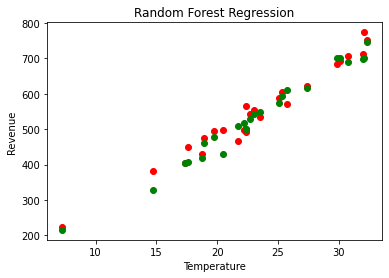

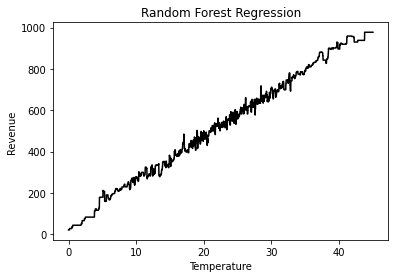

In [8]:
y_pred = regressor.predict(X_test.reshape(-1,1))
y_pred

df = pd.DataFrame({'Real Values':y_test.reshape(-1), 'Predicted Values':y_pred.reshape(-1)})
df

# # Visualising the Random Forest Regression Results  
X_grid = np.arange(min(X), max(X), 0.01)
X_grid = X_grid.reshape((len(X_grid), 1))

plt.figure()
plt.scatter(X_test, y_test, color = 'red')
plt.scatter(X_test, y_pred, color = 'green')
plt.title('Random Forest Regression')
plt.xlabel('Temperature')
plt.ylabel('Revenue')
plt.show()

plt.figure()
plt.plot(X_grid, regressor.predict(X_grid), color = 'black')
plt.title('Random Forest Regression')
plt.xlabel('Temperature')
plt.ylabel('Revenue')
plt.show()

**Some insights**  
[A limitation of Random Forest Regression](https://towardsdatascience.com/a-limitation-of-random-forest-regression-db8ed7419e9f)  

**Decision Tree regression**  
[Decision Tree - Regression](https://www.saedsayad.com/decision_tree_reg.htm)  

In [8]:

vegetables = ["오이", "토마토", "lettuce", "asparagus",
              "potato", "wheat", "barley"]
farmers = ["농부 조", "홍길동", "Smith Gardening",
           "Agrifun", "Organiculture", "BioGoods Ltd.", "Cornylee Corp."]

harvest = np.array([[0.8, 2.4, 2.5, 3.9, 0.0, 4.0, 0.0],
                    [2.4, 0.0, 4.0, 1.0, 2.7, 0.0, 0.0],
                    [1.1, 2.4, 0.8, 4.3, 1.9, 4.4, 0.0],
                    [0.6, 0.0, 0.3, 0.0, 3.1, 0.0, 0.0],
                    [0.7, 1.7, 0.6, 2.6, 2.2, 6.2, 0.0],
                    [1.3, 1.2, 0.0, 0.0, 0.0, 3.2, 5.1],
                    [0.1, 2.0, 0.0, 1.4, 0.0, 1.9, 6.3]])


fig, ax = plt.subplots()
im = ax.imshow(harvest)

# We want to show all ticks...
ax.set_xticks(np.arange(len(farmers)))
ax.set_yticks(np.arange(len(vegetables)))
# ... and label them with the respective list entries
ax.set_xticklabels(farmers, font_properties=fprop)
ax.set_yticklabels(vegetables, font_properties=fprop)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(vegetables)):
    for j in range(len(farmers)):
        text = ax.text(j, i, harvest[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Harvest of local farmers (in tons/year)")
fig.tight_layout()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …